Just got the first 4721 quasars in DR16 and now want to go through the process of plotting and saving some of them so Keri and I can start working.

In [129]:
from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from SDSSRM_11_Pix_Filter_Trevor import pixel_filter
plt.rcParams['axes.xmargin'] = 0 #turn off whitespace in plots

In [130]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 0))  # outward by 0 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [131]:
#Open the catalog of ~750k QSOs
hdul = fits.open("DR16Q_v4.fits")
print(hdul.info(), "\n")
hdul[1].header[:30]

Filename: DR16Q_v4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU    375   750414R x 183C   [18A, D, D, J, J, I, 6A, 6A, I, D, I, D, I, I, I, K, D, I, I, D, I, D, I, D, D, I, D, 12A, D, J, 19A, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, E, 5D, 5D, 5D, E, D, D, D, D, D, D, D, D, K, K, K, K, K, K, J, J, J, 74J, 74J, 74I, 74I, B, J, 3A, J, J, J, D, D, D, D, 14A, J, D, 5E, 5D, 5E, 5D, 5E, D, D, I, D, D, D, D, I, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, I, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, 21A, D, D, E, E, D, K, D, D, E, E, E, E, E, E, E, D, I, 28A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
None 



XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2290 / length of dimension 1                          
NAXIS2  =               750414 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  183 / number of table fields                         
TTYPE1  = 'SDSS_NAME'                                                           
TFORM1  = '18A     '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'DEC     '        

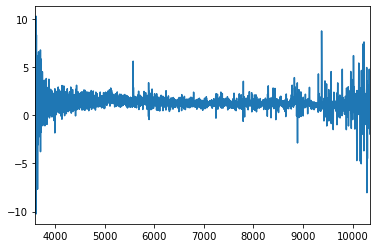

In [132]:
spec = fits.open("spectra/lite/%d/spec-6743-56385-%04d.fits" % (6743, 718))
spec[1].header

sdss_loglam = spec[1].data["LOGLAM"]
sdss_wave   = 10.**sdss_loglam
sdss_flux   = spec[1].data["FLUX"]

plt.plot(sdss_wave, sdss_flux)

In [133]:
data = hdul[1].data

#Pick out some columns that might be useful
#Need to convert data from big- to little-endian for pandas

d = {
    "names" : data['SDSS_NAME'].byteswap().newbyteorder(),
    "plate" : data['PLATE'].byteswap().newbyteorder(),
    "mjd"   : data['MJD'].byteswap().newbyteorder(),
    "fiber" : data['FIBERID'].byteswap().newbyteorder(),
    "z"     : data['Z'].byteswap().newbyteorder(),             #best identified redshift 
    "z_vi"  : data['Z_VI'].byteswap().newbyteorder(),          #redshift from visual inspection
    "z_src" : data['SOURCE_Z'].byteswap().newbyteorder(),      #source of best-redshift determination
    "S2N"   : data['SN_MEDIAN_ALL'].byteswap().newbyteorder(), #median S/N of pixels (rough way to sort)
    "BAL"   : data["BAL_PROB"].byteswap().newbyteorder()
    
}

In [134]:
np.array([d["S2N"], d["z"]]).T[((d["z"]>0.1)&(d["z"]<0.3))]
d["plate"][((d["z"]>0.1)&(d["z"]<0.3))][-1], d["mjd"][((d["z"]>0.1)&(d["z"]<0.3))][-1], d["fiber"][((d["z"]>0.1)&(d["z"]<0.3))][-1]

(7751, 58081, 8)

In [135]:
(data["IS_QSO_FINAL"]==1).sum(), len(data), "and I got 750,352 from the SDSS database"

(749749, 750414, 'and I got 750,352 from the SDSS database')

Hmm, so I probably didn't miss any quasars in my bulk download -- just tried to download some that weren't actually QSOs in the finals catalog.  Looks I probably downloaded some duplicates though, so should make sure that any we identify aren't also stored somewhere with a correct redshift (but maybe it'd be good to find those as well?).

In [136]:
data["SN_MEDIAN_ALL"]

array([24.46896744,  2.28859258,  1.420663  , ..., 14.48494625,
        5.33101225,  4.99468803])

In [137]:
zlist = np.array([0.00166803679894656, ])

In [138]:
df = pd.DataFrame(data=d)
#df.to_csv("quasars.csv")
df.sort_values("z", inplace=True)
df.shape, df[df["z"]==0.00166803679894656]

((750414, 9),
 Empty DataFrame
 Columns: [names, plate, mjd, fiber, z, z_vi, z_src, S2N, BAL]
 Index: [])

In [139]:
df.iloc[0]

names    105847.65+111115.8
plate                  5356
mjd                   55979
fiber                   876
z                      -999
z_vi                   -999
z_src                    VI
S2N                 7.33038
BAL                      -1
Name: 336175, dtype: object

In [140]:
len((df[df["z"]==1.0]))

89

In [141]:
df["z"][df["z"]==0.1]

Series([], Name: z, dtype: float64)

In [142]:
dframe = df[((df["z"]>0.95)&(df["z"]<1.5))]
len(dframe)

184424

In [143]:
dframe.iloc[len(dframe)//2]

names    103212.49+355412.1
plate                 10274
mjd                   58170
fiber                   959
z                    1.2456
z_vi                     -1
z_src                  PIPE
S2N                 10.4051
BAL                      -1
Name: 310245, dtype: object

See how spectra change with z - just to get a rough handle on what may be the best way to split these up into images

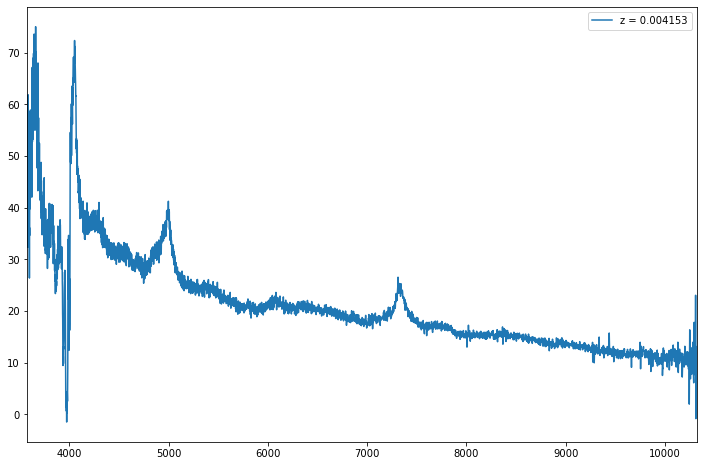

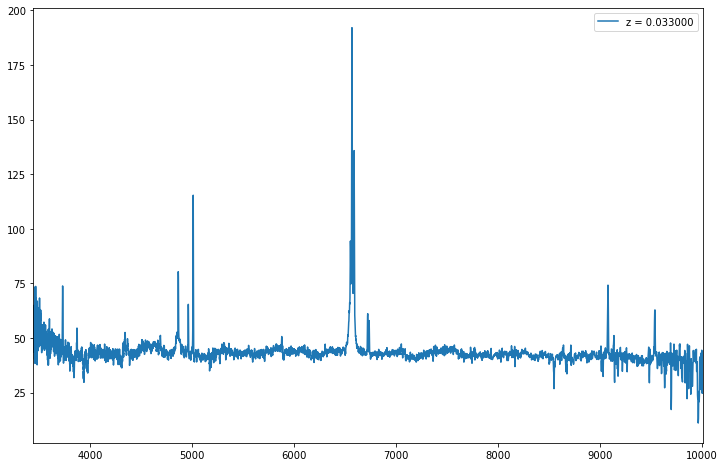

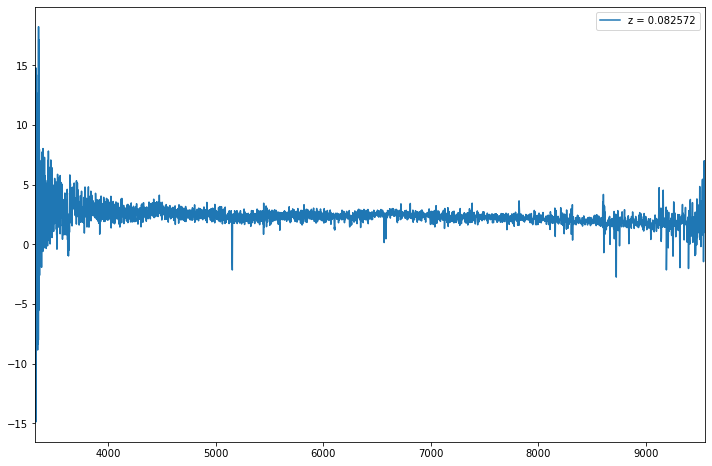

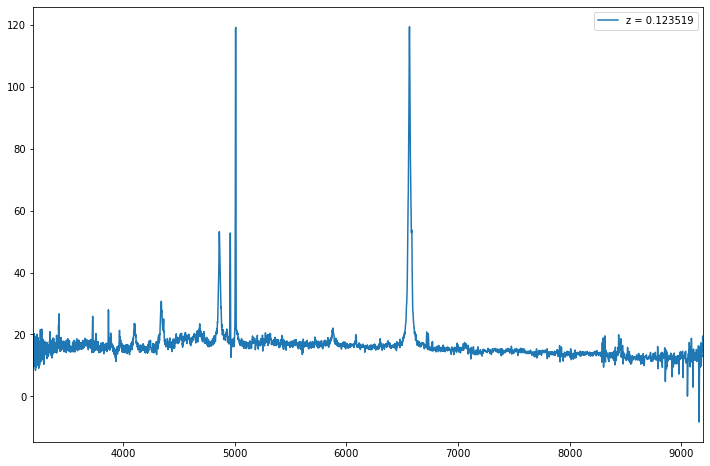

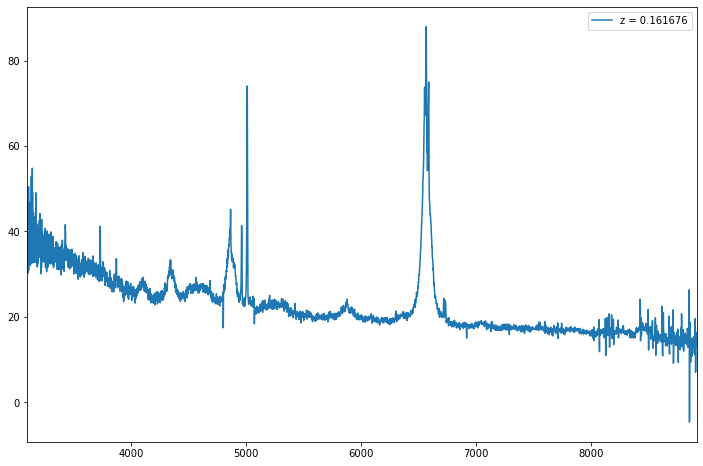

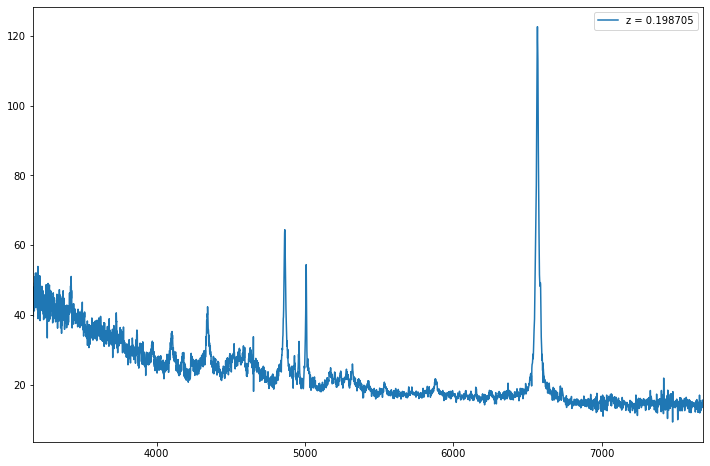

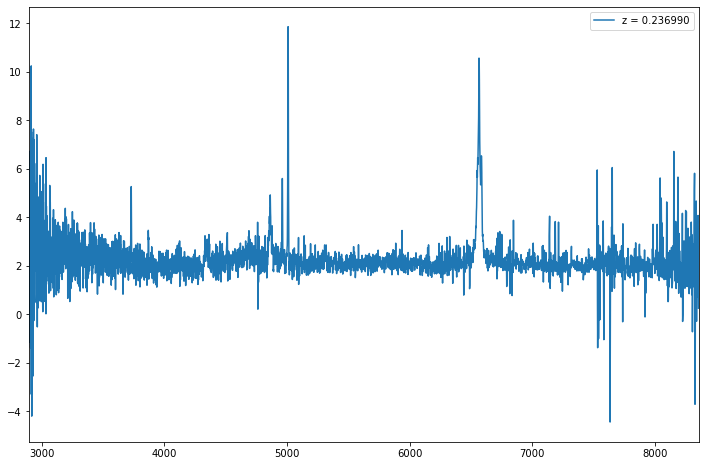

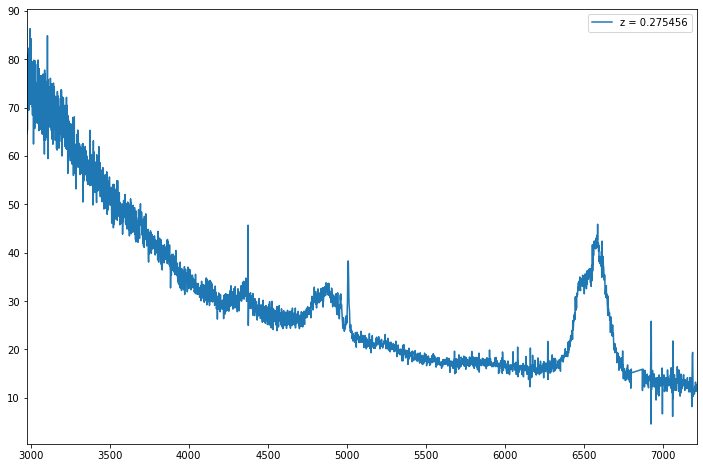

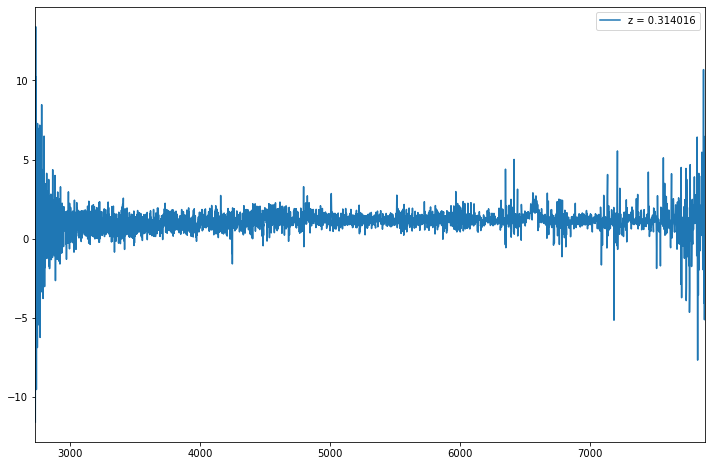

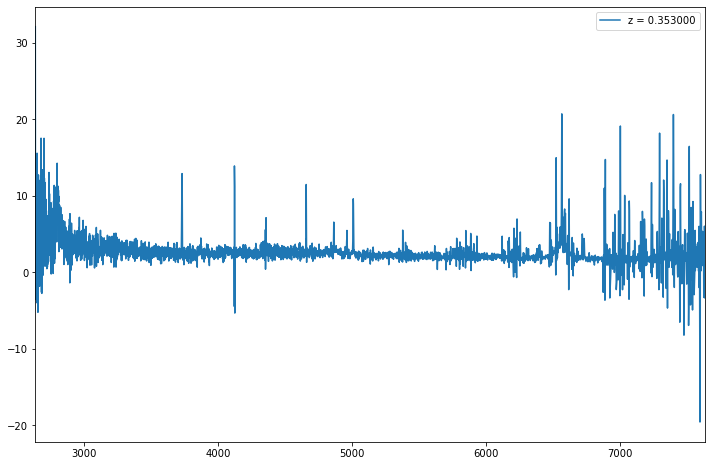

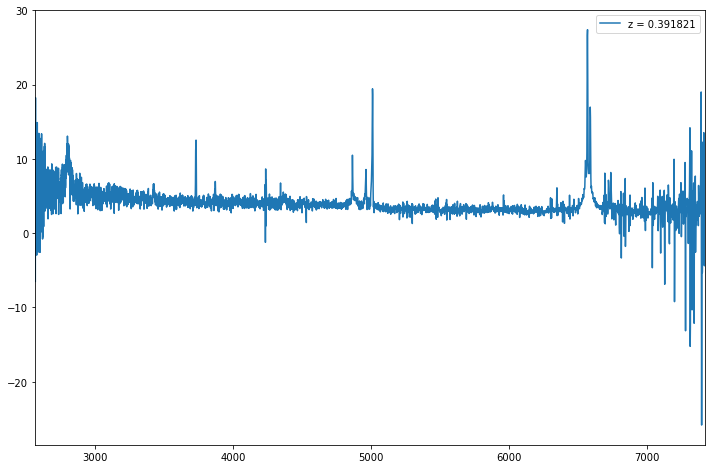

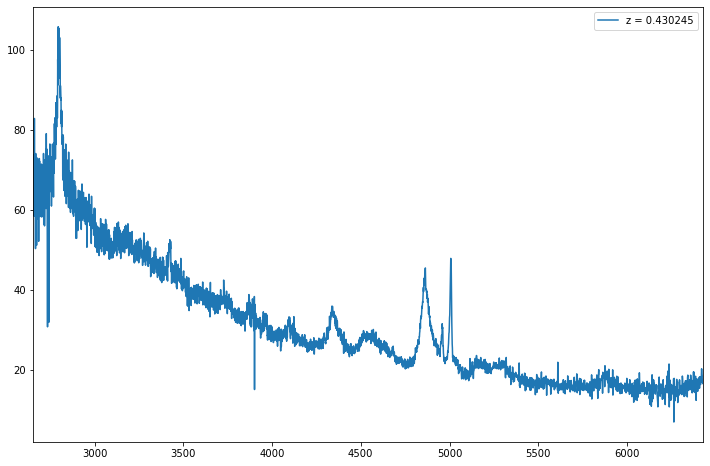

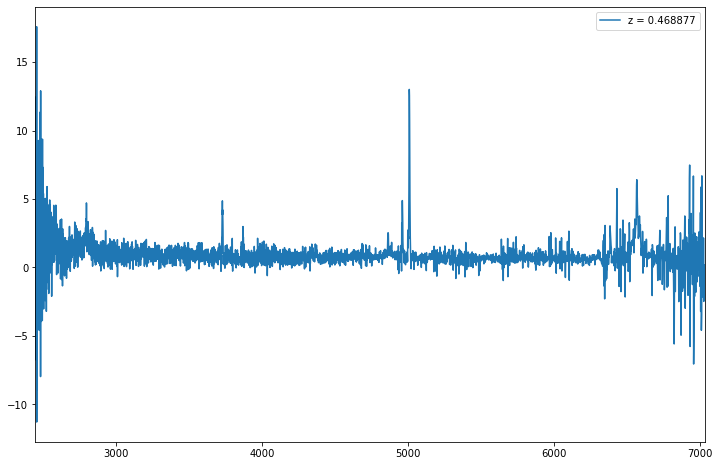

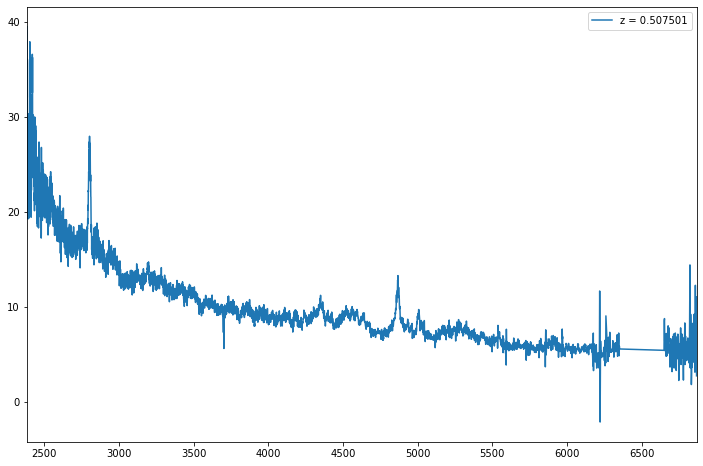

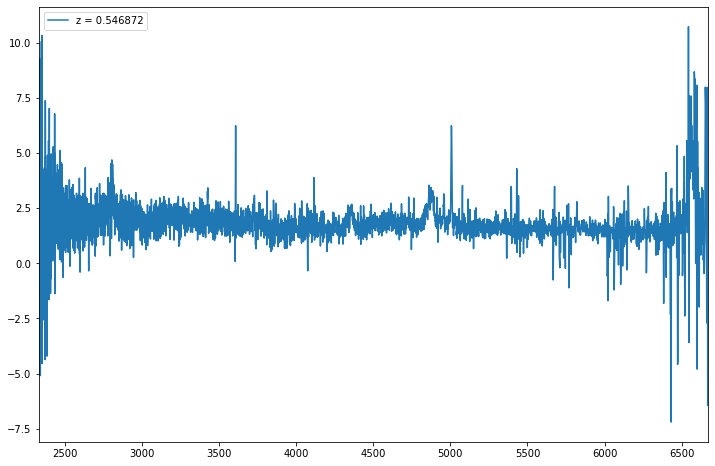

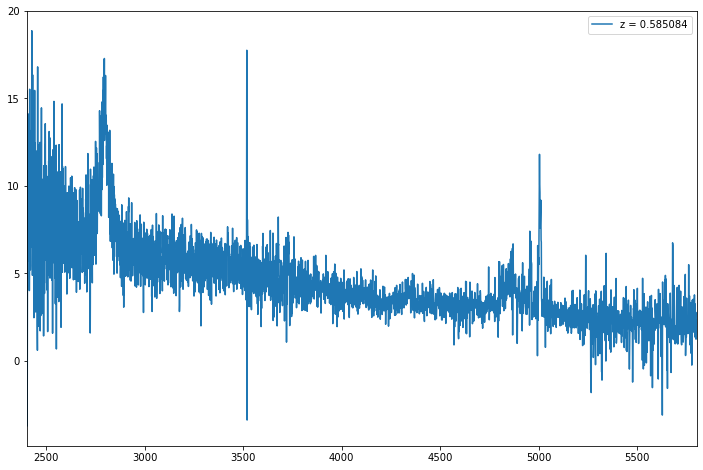

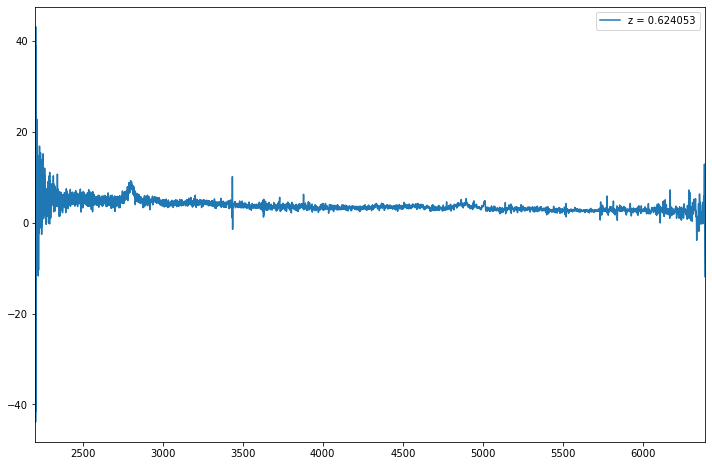

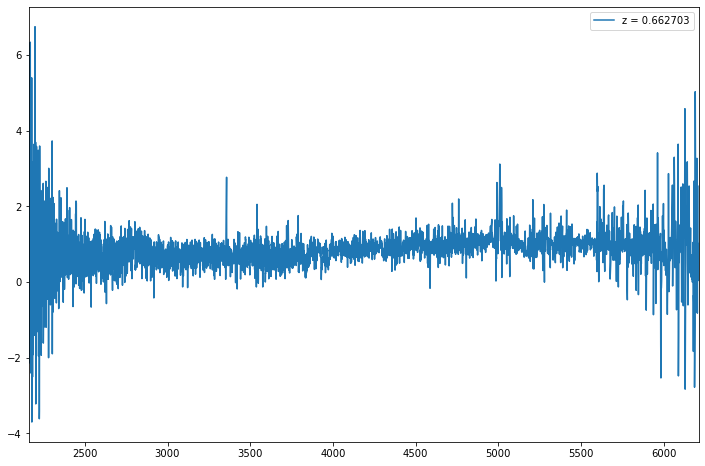

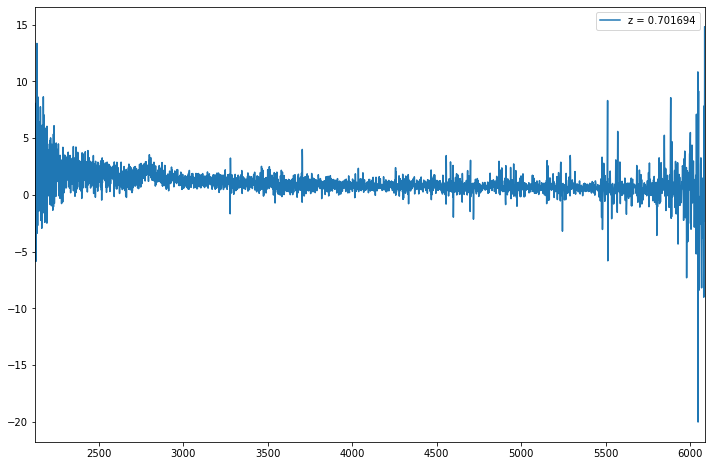

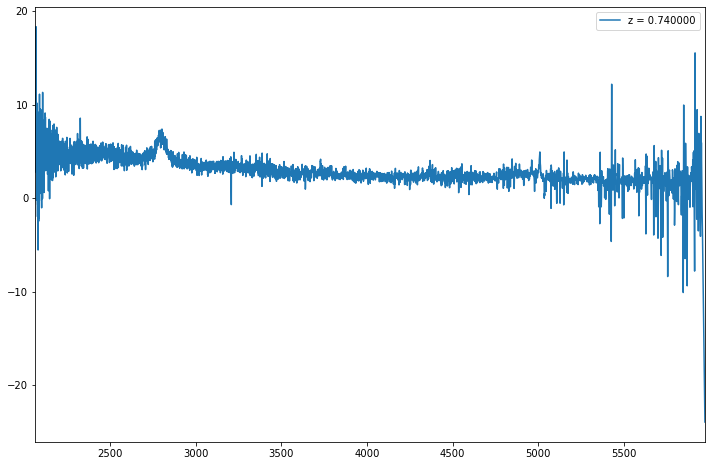

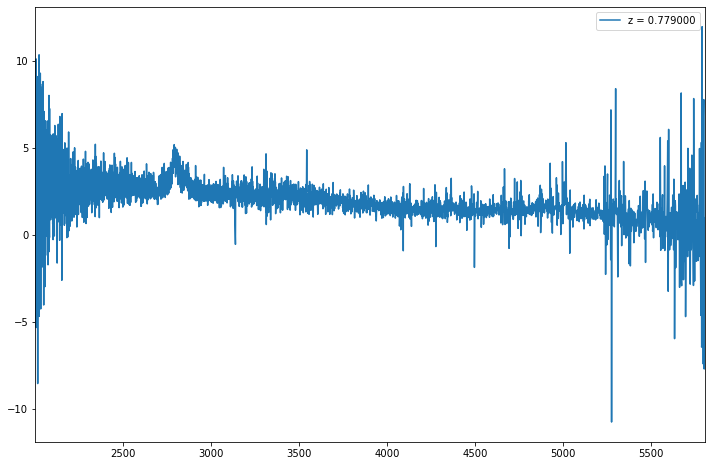

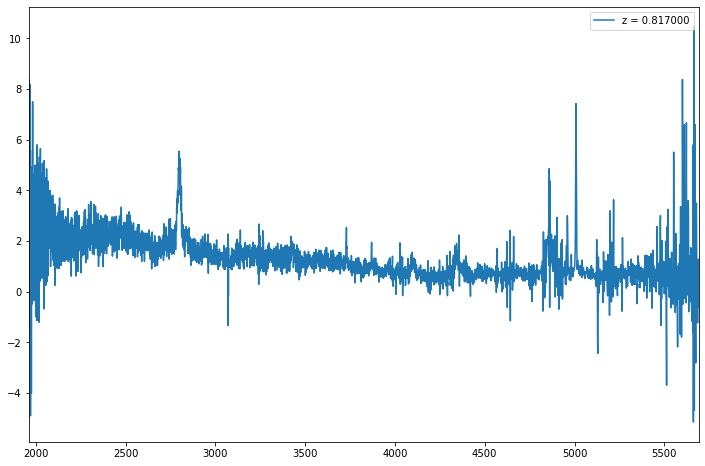

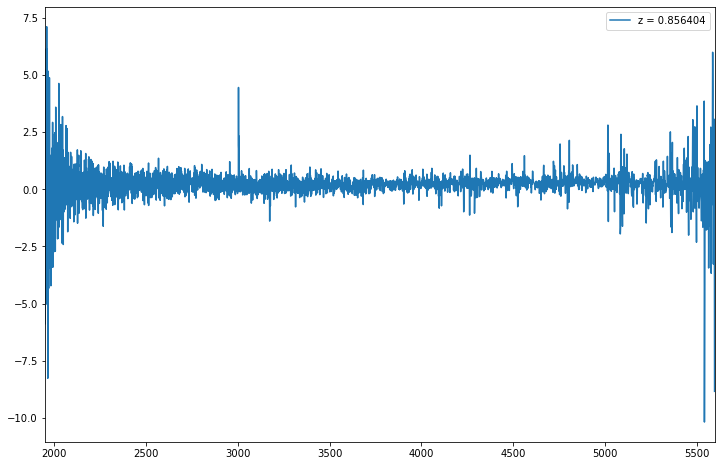

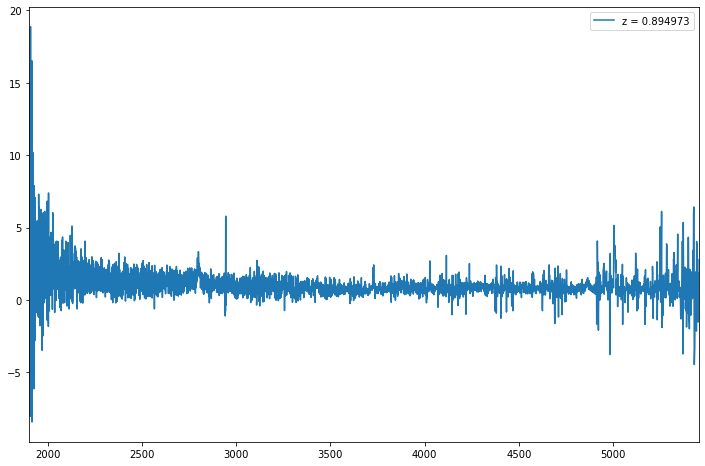

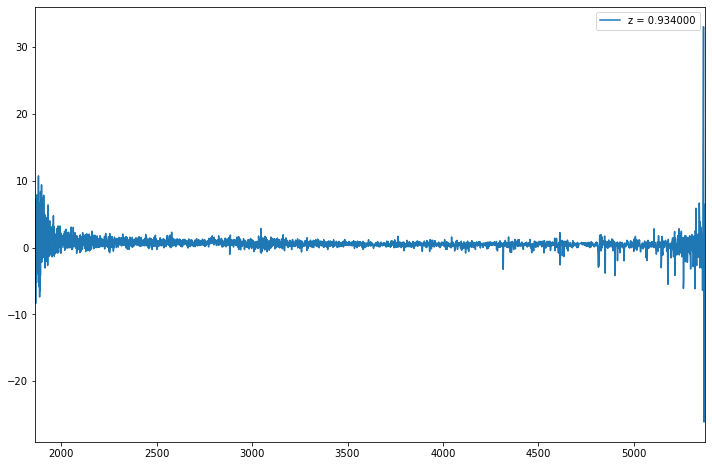

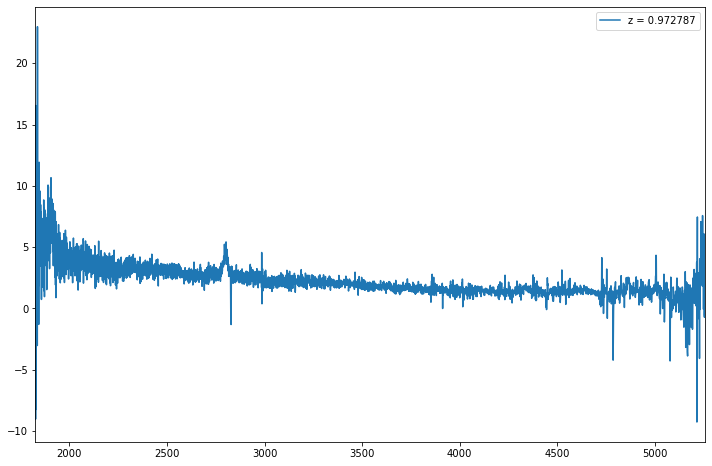

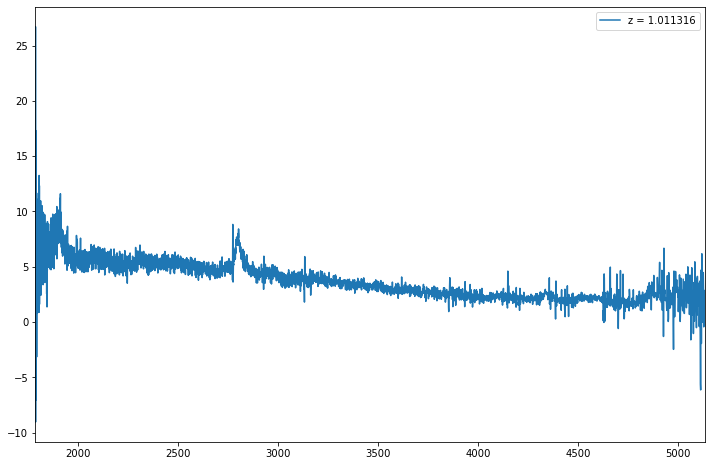

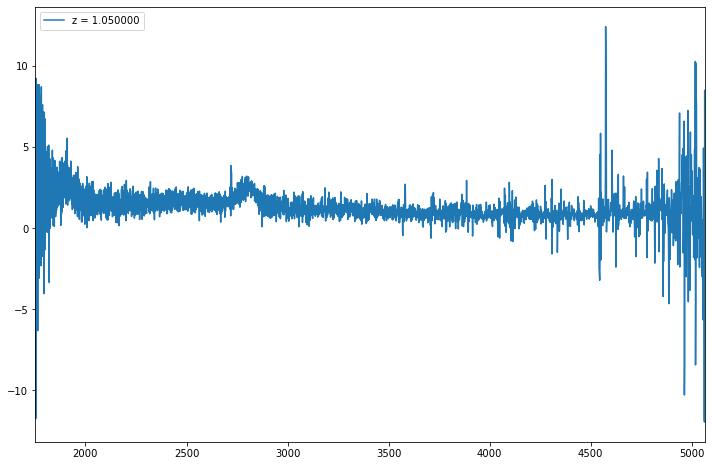

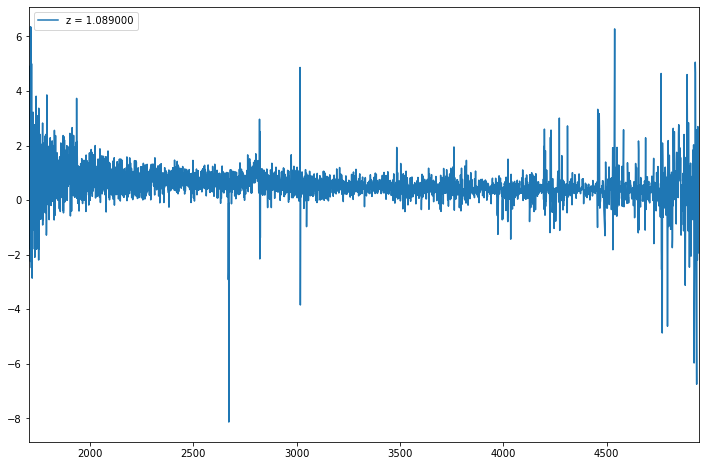

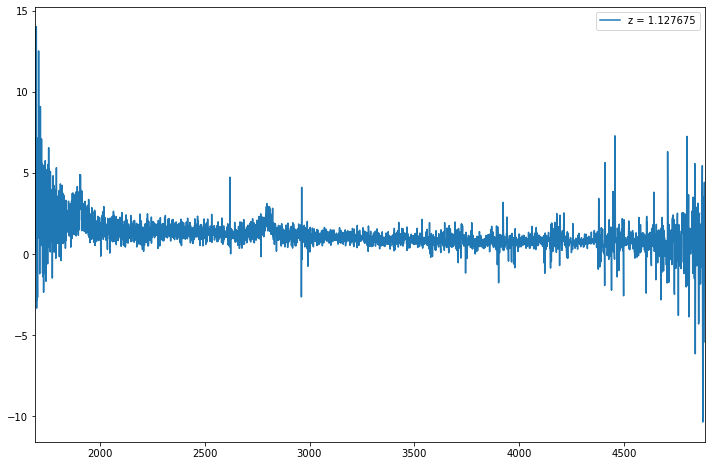

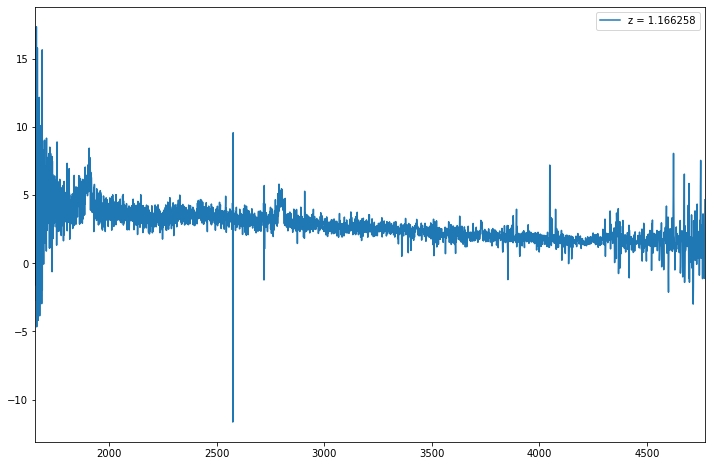

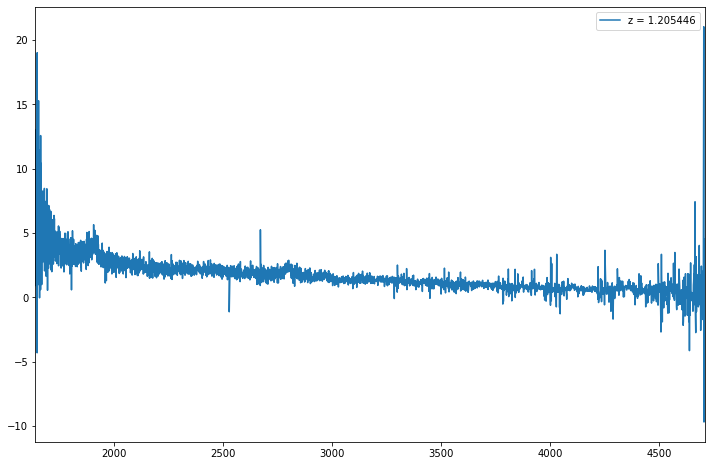

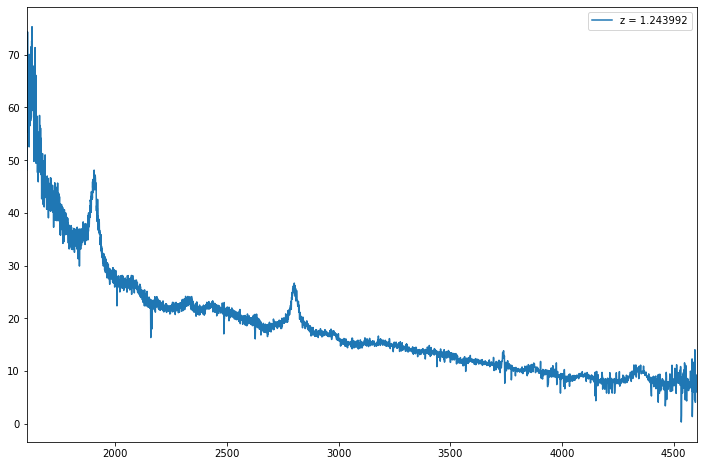

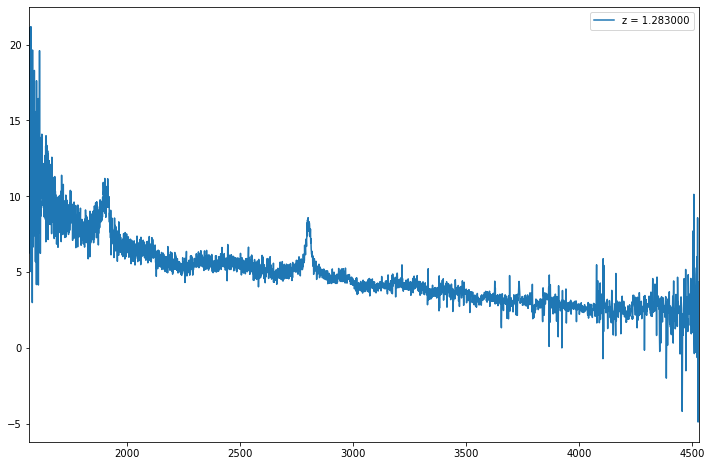

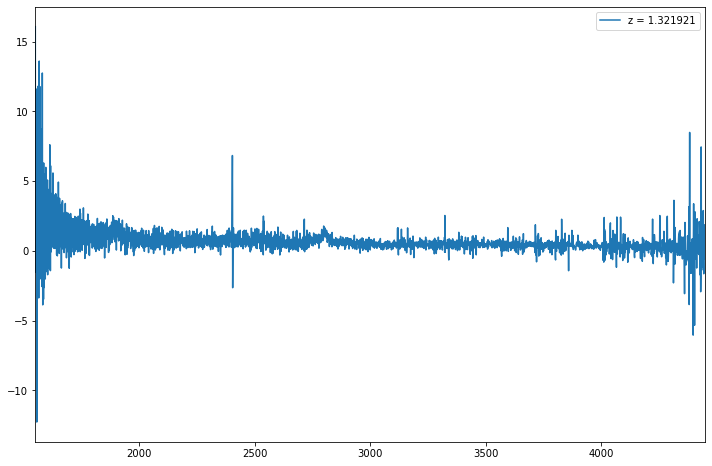

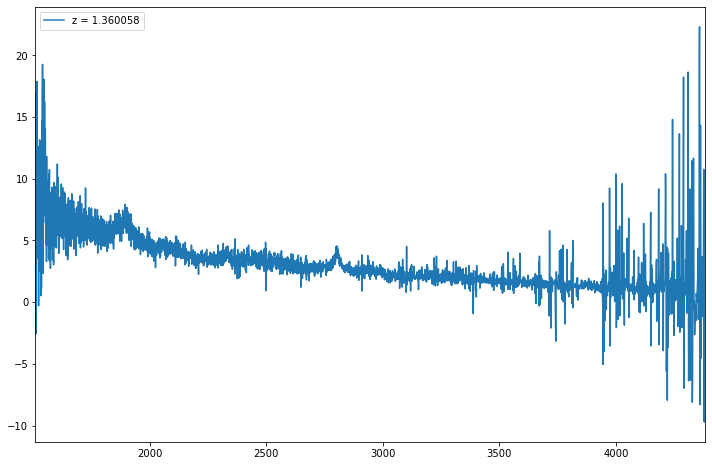

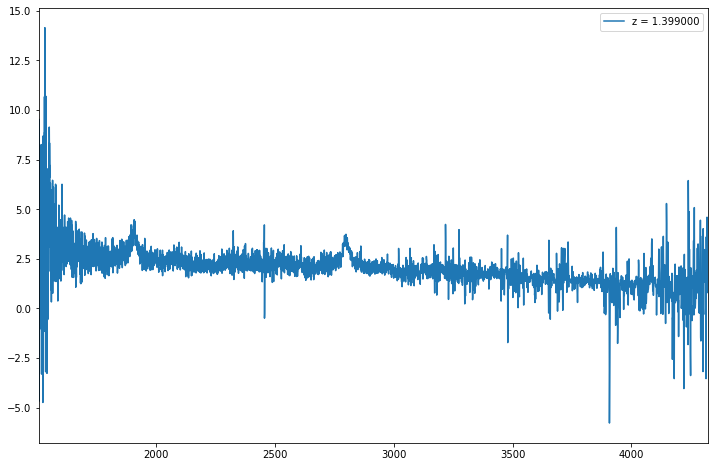

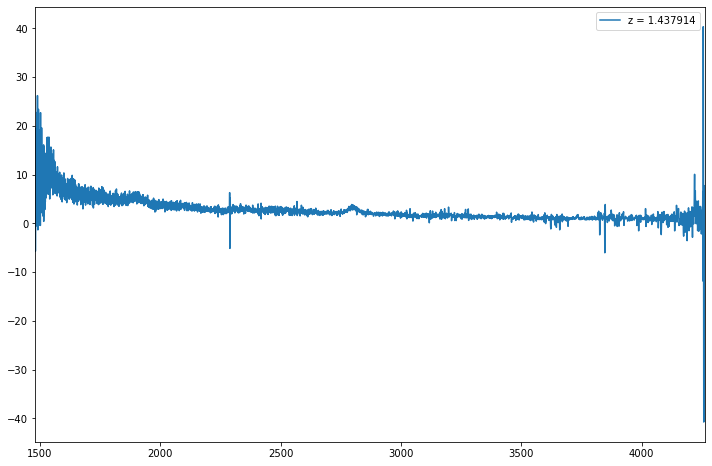

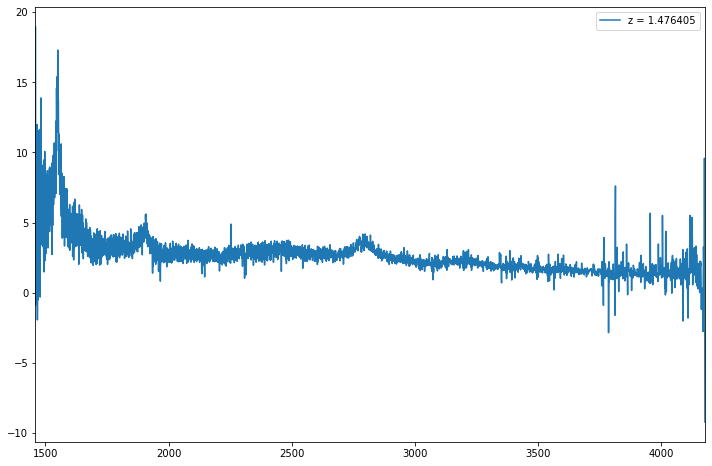

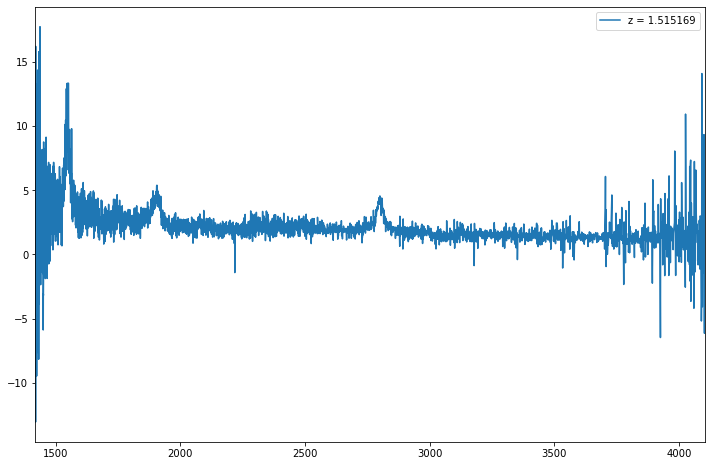

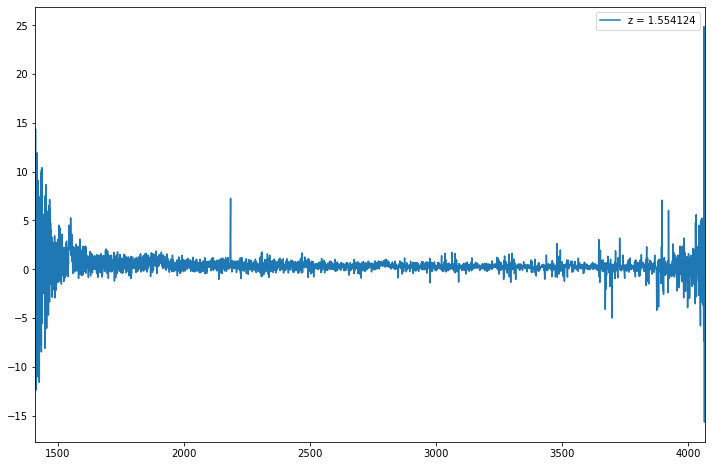

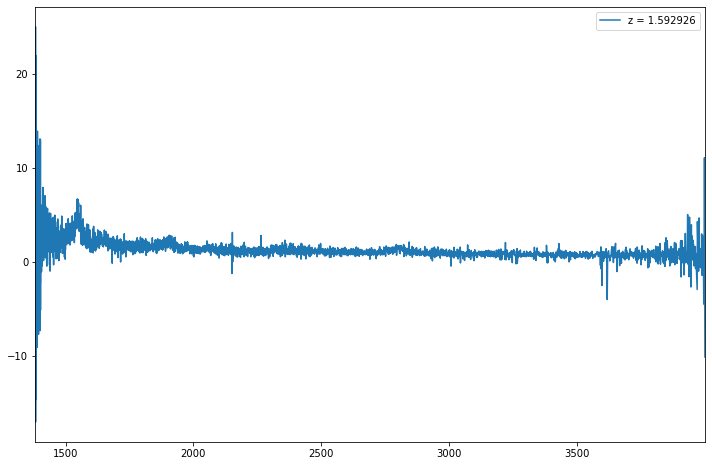

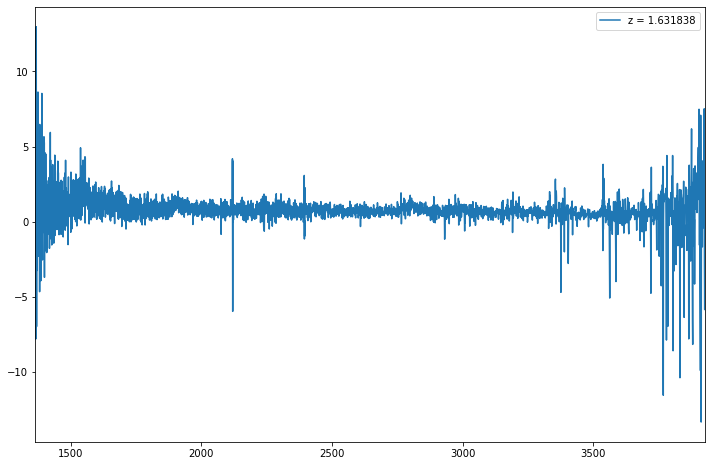

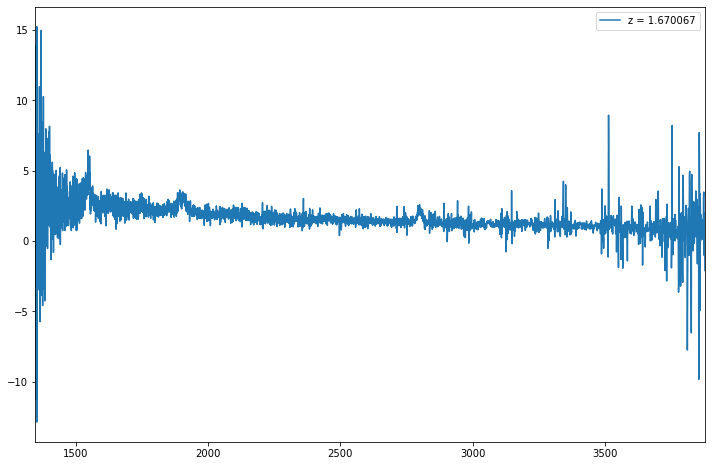

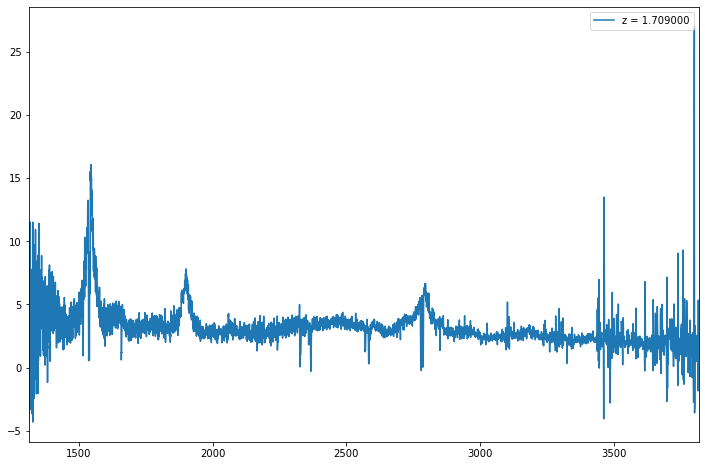

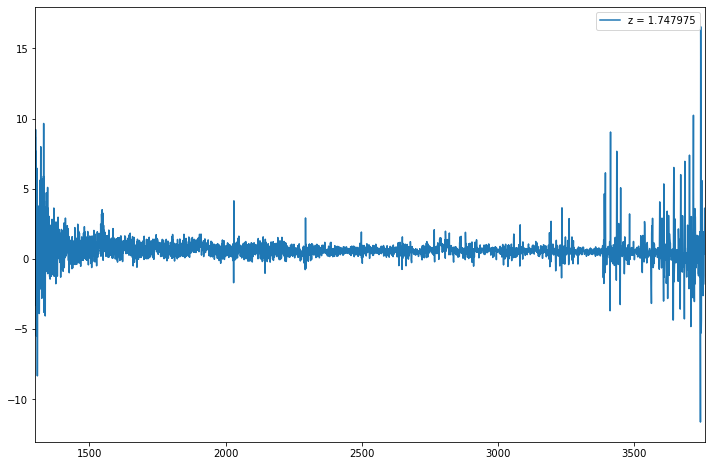

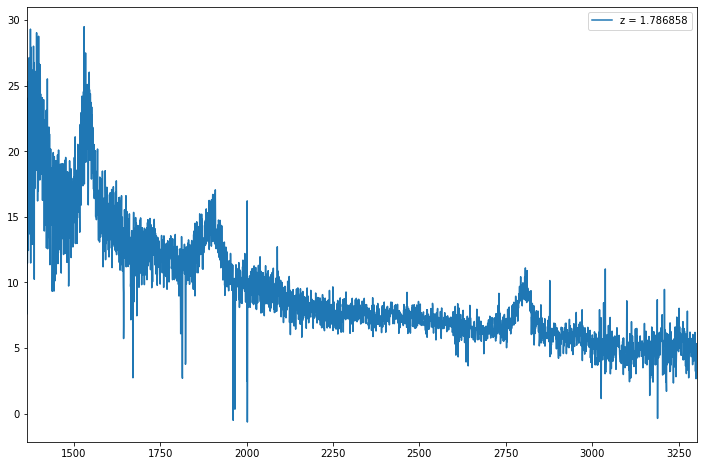

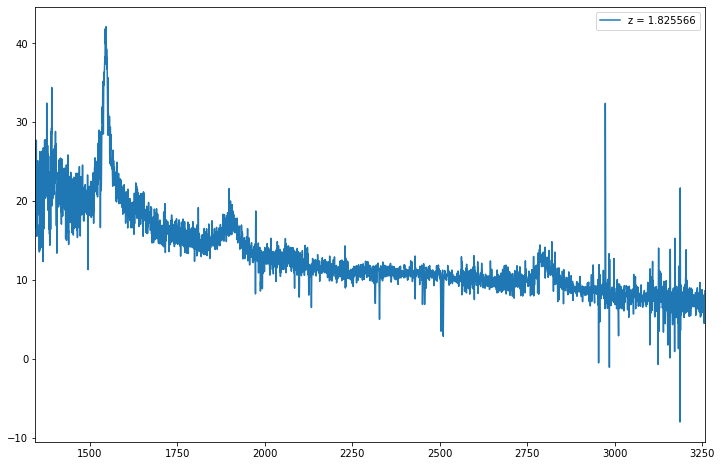

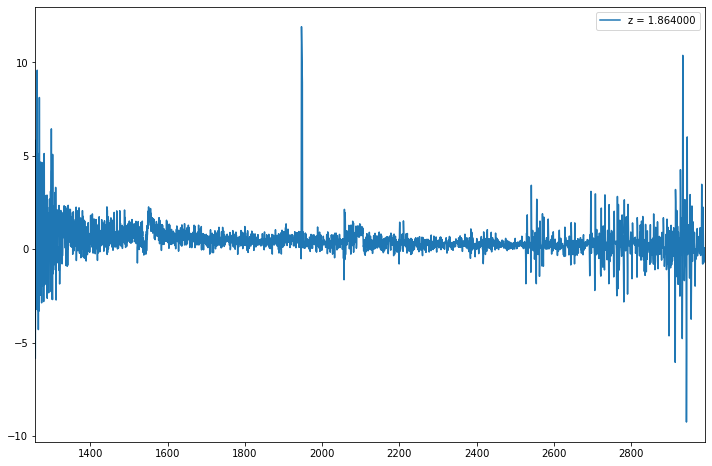

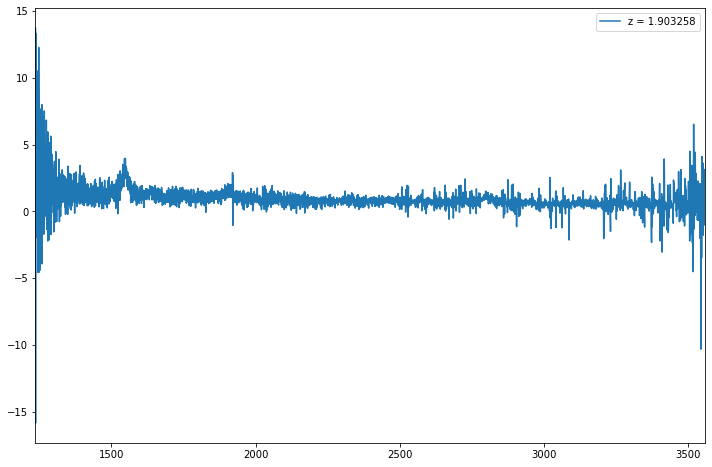

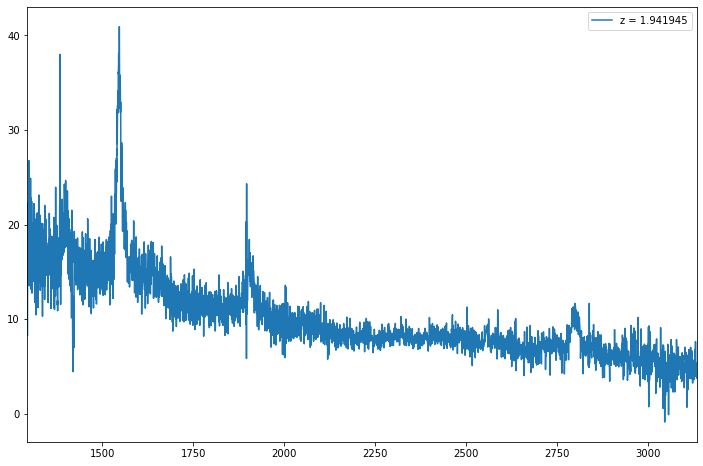

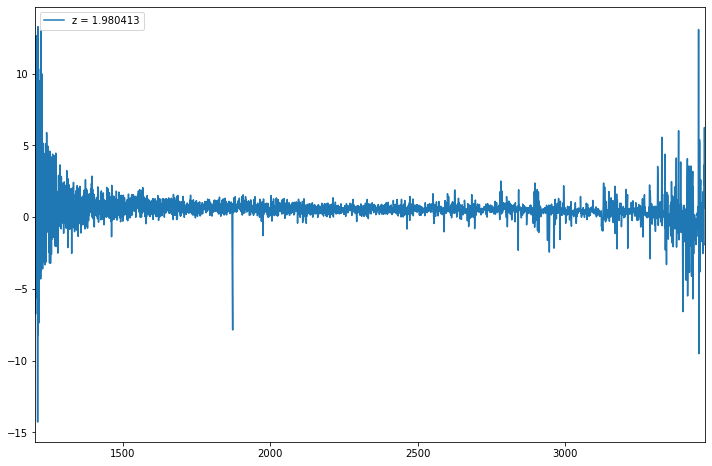

In [144]:
#Plot different spectra in these intervals
zlist = np.array([0.0, 0.01, 0.05])
zlist = np.append(zlist, np.linspace(0.1, 2.0))

for i in range(len(zlist)-1):
    
    fig = plt.figure(figsize=(12,8))
    
    #Split out the sources in each interval
    dframe = df[((df["z"]>zlist[i])&(df["z"]<zlist[i+1]))]
    
    #"randomly" choose the central object in the dataframe
    randspec = dframe.iloc[len(dframe)//2]
    
    spec = fits.open("spectra/lite/%04d/spec-%04d-%d-%04d.fits" \
                    % (randspec["plate"], randspec["plate"], randspec["mjd"], randspec["fiber"]))

    sdss_loglam = spec[1].data["LOGLAM"]
    sdss_wave   = (10.**sdss_loglam)/(1+randspec["z"])
    sdss_flux   = spec[1].data["FLUX"]

    plt.plot(sdss_wave, sdss_flux, label="z = %4f" % (randspec["z"]))
    
    
    
    plt.legend(loc="best")
    plt.show()

In [145]:
#Take this redshift range for this notebook, then sort by S/N
dframe = df[((df["z"]>1.1)&(df["z"]<1.2))]
dframe.sort_values("S2N", ascending=False, inplace=True)
len(dframe)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


32400

In [146]:
(dframe["BAL"]<=0.).sum()

32400

In [147]:
dframe["names"].iloc[0]

'103230.02+222015.9'

In [148]:
FNF = np.append(FNF, 'hello')
FNF

array(['hello'], dtype='<U32')

In [149]:
%%capture

N = 30 #number to plot on a page 
FNF = np.array([]) #save 'missing' spectra
DPI = 15 #resolution of plots

fig, axs = plt.subplots(30, 1, figsize=(6,50), dpi=DPI)   #dpi good for degrading resolution of plots
plt.setp(axs, xticks=[], yticks=[])                      #Don't want any ticks or labels

for i in range(len(dframe)):   
    
    if (((i%N)==0) and i>0):
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)   #remove whitespace between subplots
        plt.savefig("z_1p1_1p2/stack30_1p1_z_1p2_%s_%s.png" % (dframe["names"].iloc[i-N], \
                                                               dframe["names"].iloc[i-1]))
        fig, axs = plt.subplots(30, 1, figsize=(6,50), dpi=DPI)  #dpi good for degrading resolution of plots
        plt.setp(axs, xticks=[], yticks=[])                      #Don't want any ticks or labels
        
    #Comment out this line to get all spectra from this redshift range
    #if i>=90: break
    
    try:
        spec = fits.open("spectra/lite/%04d/spec-%04d-%d-%04d.fits" \
                        % (dframe.iloc[i]["plate"], dframe.iloc[i]["plate"], \
                           dframe.iloc[i]["mjd"], dframe.iloc[i]["fiber"]))
    
    except FileNotFoundError: #some plate/mjd/fiber combos weren't in SDSS database
        FNF = np.append(FNF, dframe["names"].iloc[i])
        i -= 1
        continue

    #Read in data for each spectrum
    sdss_loglam = spec[1].data["LOGLAM"]
    sdss_wave   = (10.**sdss_loglam)/(1+dframe.iloc[i]["z"])
    
    #Easier to handle smoothing/whitespace this way
    wave_range= ((sdss_wave>=1850)&(sdss_wave<=2850))
    sdss_wave = sdss_wave[wave_range]
    sdss_flux = spec[1].data["FLUX"][wave_range]
    flux_error= (1/np.sqrt(spec[1].data["ivar"][wave_range]))
    mask_array= spec[1].data["AND_MASK"][wave_range]
    
    #take the median flux / fluxerror / S2N from Angelica's pixel filter
    continuum = [pixel_filter(sdss_wave, sdss_flux, flux_error, "Fluxes"), 
                 pixel_filter(sdss_wave, sdss_flux, flux_error, "Fluxerrs"),
                 pixel_filter(sdss_wave, sdss_flux, flux_error, "S/N")]
    
    emission1 = (sdss_wave>1860)&(sdss_wave<2000)
    emission2 = (sdss_wave>2725)&(sdss_wave<2850)
    emission_space = ((emission1)|(emission2)) #define indices for emission lines
    
    skylines  = (((sdss_wave>2468)&(sdss_wave<2498))|((sdss_wave>2609)&(sdss_wave<2643)))

    #Handle bad pixels (masked by SDSS)
    mask_array[emission_space] = 0. #emisson line pixels are not bad
    bad_pixels = (mask_array>0) #sdss pipeline bad pixels
    for j in range(len(sdss_flux)):
        if (bad_pixels[j] or skylines[j]) and not emission_space[j]:
            sdss_flux[j] = np.median(np.concatenate((sdss_flux[j-2:j],sdss_flux[j+1:j+3])))
            flux_error[j] = 0.
            
    #Now WE find the bad pixels, replace with median (i.e. continuum[0])
    for k in range(len(continuum[0])):       
        if (abs(sdss_flux[k]-continuum[0][k])>continuum[1][k]*3.0):
            sdss_flux[k]=continuum[0][k] #flux goes to median spectrum
            flux_error[k]=0.0 #continuum[1][i] #new flux error is equal to that of the median spectrum's flux error
            mask_array[k]+=(2**30) 
                        
    
    
    axs[i%30].plot(sdss_wave, sdss_flux)
    adjust_spines(axs[i%30], [])

In [159]:
! ls -1 z_1p1_1p2/ | wc -l

    1079


The above loop missed the last 28 objects since two were missing

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered 

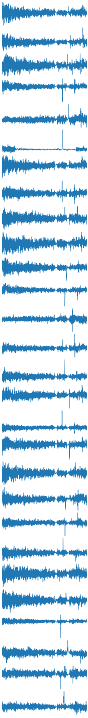

In [161]:
fig, axs = plt.subplots(28, 1, figsize=(6,48), dpi=DPI)  #dpi good for degrading resolution of plots
plt.setp(axs, xticks=[], yticks=[])                      #Don't want any ticks or labels

for i in range(-28,0):    #plot the last 28 in dframe     
    
    try:
        spec = fits.open("spectra/lite/%04d/spec-%04d-%d-%04d.fits" \
                        % (dframe.iloc[i]["plate"], dframe.iloc[i]["plate"], \
                           dframe.iloc[i]["mjd"], dframe.iloc[i]["fiber"]))
    
    except FileNotFoundError: #some plate/mjd/fiber combos weren't in SDSS database
        FNF = np.append(FNF, dframe["names"].iloc[i])
        i -= 1
        continue

    #Read in data for each spectrum
    sdss_loglam = spec[1].data["LOGLAM"]
    sdss_wave   = (10.**sdss_loglam)/(1+dframe.iloc[i]["z"])
    
    #Easier to handle smoothing/whitespace this way
    wave_range= ((sdss_wave>=1850)&(sdss_wave<=2850))
    sdss_wave = sdss_wave[wave_range]
    sdss_flux = spec[1].data["FLUX"][wave_range]
    flux_error= (1/np.sqrt(spec[1].data["ivar"][wave_range]))
    mask_array= spec[1].data["AND_MASK"][wave_range]
    
    #take the median flux / fluxerror / S2N from Angelica's pixel filter
    continuum = [pixel_filter(sdss_wave, sdss_flux, flux_error, "Fluxes"), 
                 pixel_filter(sdss_wave, sdss_flux, flux_error, "Fluxerrs"),
                 pixel_filter(sdss_wave, sdss_flux, flux_error, "S/N")]
    
    emission1 = (sdss_wave>1860)&(sdss_wave<2000)
    emission2 = (sdss_wave>2725)&(sdss_wave<2850)
    emission_space = ((emission1)|(emission2)) #define indices for emission lines
    
    skylines  = (((sdss_wave>2468)&(sdss_wave<2498))|((sdss_wave>2609)&(sdss_wave<2643)))

    #Handle bad pixels (masked by SDSS)
    mask_array[emission_space] = 0. #emisson line pixels are not bad
    bad_pixels = (mask_array>0) #sdss pipeline bad pixels
    for j in range(len(sdss_flux)):
        if (bad_pixels[j] or skylines[j]) and not emission_space[j]:
            sdss_flux[j] = np.median(np.concatenate((sdss_flux[j-2:j],sdss_flux[j+1:j+3])))
            flux_error[j] = 0.
            
    #Now WE find the bad pixels, replace with median (i.e. continuum[0])
    for k in range(len(continuum[0])):       
        if (abs(sdss_flux[k]-continuum[0][k])>continuum[1][k]*3.0):
            sdss_flux[k]=continuum[0][k] #flux goes to median spectrum
            flux_error[k]=0.0 #continuum[1][i] #new flux error is equal to that of the median spectrum's flux error
            mask_array[k]+=(2**30) 
                        
    
    
    axs[i].plot(sdss_wave, sdss_flux)
    adjust_spines(axs[i], [])
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)   #remove whitespace between subplots
plt.savefig("z_1p1_1p2/stack30_1p1_z_1p2_%s_%s.png" % (dframe["names"].iloc[i-28], \
                                                       dframe["names"].iloc[i-1]))

Missing these two quasars and plot of final 28 did not save

In [150]:
dframe.head(30)

,names,plate,mjd,fiber,z,z_vi,z_src,S2N,BAL
310510,103230.02+222015.9,6425,56298,288,1.123000,1.123,VI,76.351509,-1.0
701300,225409.59+005629.1,4206,55471,838,1.156000,1.156,VI,60.402584,-1.0
315661,103743.00+240641.1,6425,56298,941,1.116000,1.116,VI,55.273033,-1.0
183061,082226.81+475059.1,3692,55186,912,1.126000,1.126,VI,52.995224,-1.0
298372,102002.85-015218.7,3770,55234,534,1.133000,1.133,VI,49.368484,-1.0
400197,120813.42+023015.1,517,52024,509,1.182170,-1.000,DR6Q_HW,49.347828,-1.0
187602,082726.02+331354.6,4442,55532,222,1.117000,1.117,VI,49.052078,-1.0
154208,074816.97+422509.3,3669,55481,92,1.107000,1.107,VI,48.372025,-1.0
400856,120858.01+454035.4,1370,53090,360,1.164941,-1.000,DR6Q_HW,47.744110,-1.0
537728,144313.32+094910.2,5472,55976,704,1.193000,1.193,VI,47.439026,-1.0


# fig = plt.figure(figsize=(12,10))
_ = plt.hist(data["BAL_PROB"], bins="scott")

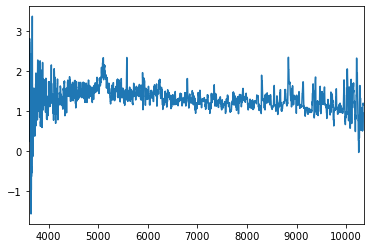

In [88]:
spec = fits.open("spectra/lite/%d/spec-6743-56385-%04d.fits" % (6743, 718))
spec[1].header

sdss_loglam = spec[1].data["LOGLAM"]
sdss_wave   = 10.**sdss_loglam
sdss_flux   = spec[1].data["FLUX"]

#plt.plot(sdss_wave, sdss_flux)
plt.plot(sdss_wave, pixel_filter(sdss_wave, sdss_flux))

In [19]:
spec[1].data["ivar"]

array([0.09112314, 0.        , 0.09155988, ..., 0.16741666, 0.1665565 ,
       0.15588118], dtype=float32)

In [77]:
pixel_filter(sdss_wave, sdss_flux)

array([1.99304628, 1.99304628, 1.99304628, ..., 1.1640836 , 1.1640836 ,
       1.1640836 ])

In [40]:
dframe.head(30)

,names,plate,mjd,fiber,z,z_vi,z_src,S2N,BAL
310510,103230.02+222015.9,6425,56298,288,1.123000,1.123,VI,76.351509,-1.0
701300,225409.59+005629.1,4206,55471,838,1.156000,1.156,VI,60.402584,-1.0
315661,103743.00+240641.1,6425,56298,941,1.116000,1.116,VI,55.273033,-1.0
183061,082226.81+475059.1,3692,55186,912,1.126000,1.126,VI,52.995224,-1.0
298372,102002.85-015218.7,3770,55234,534,1.133000,1.133,VI,49.368484,-1.0
400197,120813.42+023015.1,517,52024,509,1.182170,-1.000,DR6Q_HW,49.347828,-1.0
187602,082726.02+331354.6,4442,55532,222,1.117000,1.117,VI,49.052078,-1.0
154208,074816.97+422509.3,3669,55481,92,1.107000,1.107,VI,48.372025,-1.0
400856,120858.01+454035.4,1370,53090,360,1.164941,-1.000,DR6Q_HW,47.744110,-1.0
537728,144313.32+094910.2,5472,55976,704,1.193000,1.193,VI,47.439026,-1.0


----

Now let's make some plots that may be easier to feed to algorithms while we're trying to build a foundation:

- A plot with the same spectrum plotted 30 times (just one -- we can make as many copies as we like)
- A plot with one **very** incorrect redshift/wavelength coverage
- Maybe plots with two or three incorrect redshifts as well

In [88]:
#A z=0.24 quasar with decent S2N
spec_bad = fits.open("spectra/lite/7751/spec-7751-58081-0008.fits")

loglam_bad = spec_bad[1].data["LOGLAM"]
wave_bad   = 10.**loglam_bad
mask_bad   = ((wave_bad>7500)&(wave_bad<9000))
wave_bad   = wave_bad[mask_bad]
#wave_bad  /= spec_bad[1].data["Z"] #need to change
flux_bad   = spec_bad[1].data["FLUX"][mask_bad]


#A z=1.12 quasar
spec_good = fits.open("spectra/lite/3861/spec-3861-55274-0422.fits")

loglam_good = spec_good[1].data["LOGLAM"]
wave_good   = 10.**loglam_good
mask_good   = ((wave_good>3778)&(wave_good<6245))
wave_good   = wave_good[mask_good]
#wave_good  /= spec_good[1].data["Z"]
flux_good   = spec_good[1].data["FLUX"][mask_good]

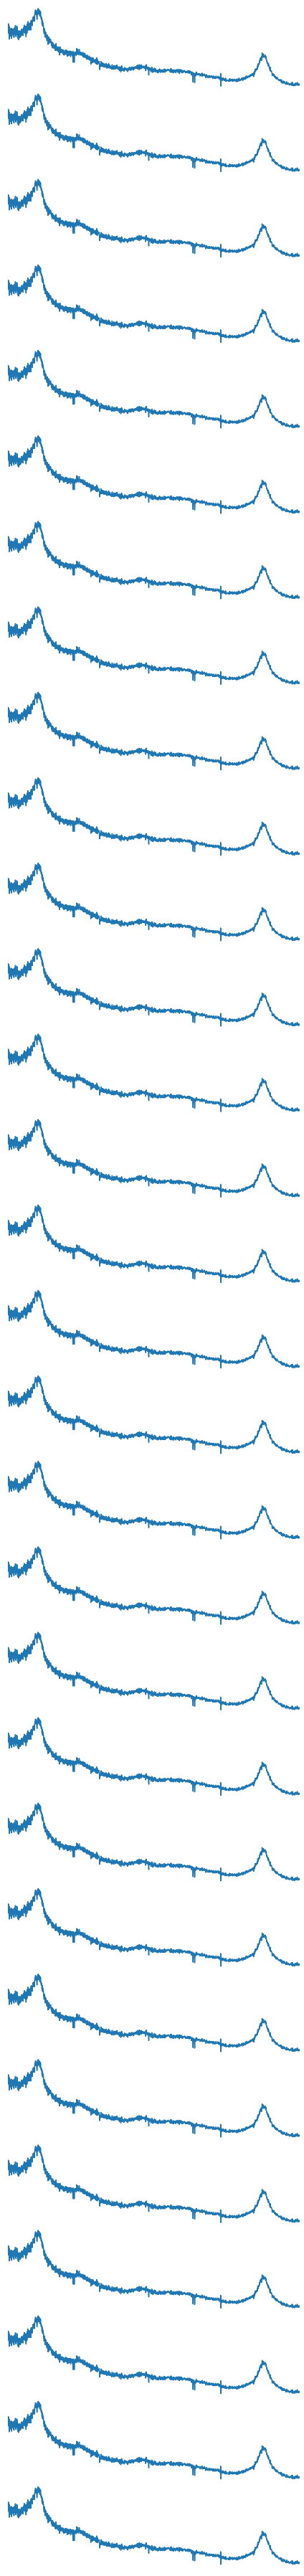

In [121]:
fig, axs = plt.subplots(30, 1, figsize=(6,50), frameon=False)#, dpi=DPI)   #dpi good for degrading resolution of plots
plt.setp(axs, xticks=[], yticks=[])                      #Don't want any ticks or labels

for i in range(N):
    axs[i].plot(wave_good, flux_good)
    adjust_spines(axs[i], [])
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0) #remove whitespace between subplots
#plt.savefig("stack30_same_lowres.png")
plt.savefig("stack30_same_highres.png") 
plt.show()

Now artificially insert a bad spectrum at different place in the page

In [123]:
%%capture

for k in range(N):
    fig, axs = plt.subplots(30, 1, figsize=(6,50), frameon=False)#, dpi=DPI)   #dpi good for degrading resolution of plots
    plt.setp(axs, xticks=[], yticks=[])                      #Don't want any ticks or labels

    for i in range(N):
        if i==k:
            axs[i].plot(wave_bad, flux_bad)
            adjust_spines(axs[i], [])
        else:
            axs[i].plot(wave_good, flux_good)
            adjust_spines(axs[i], [])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)   #remove whitespace between subplots
    plt.savefig("spectra30_1diff_highres/stack30_1diff_highres_%s.png" % str(k+1))
    #plt.savefig("spectra30_1diff_lowres/stack30_1diff_lowres_%s.png" % str(k+1))

Up the ante, insert two bad spectra (random locations)

In [125]:
%%capture

for k in range(100):
    fig, axs = plt.subplots(30, 1, figsize=(6,50), frameon=False)#, dpi=DPI)   #dpi good for degrading resolution of plots
    plt.setp(axs, xticks=[], yticks=[])                      #Don't want any ticks or labels

    inds = np.random.randint(0, N, 2)
    
    for i in range(N):
        if i in inds:
            axs[i].plot(wave_bad, flux_bad)
            adjust_spines(axs[i], [])
        else:
            axs[i].plot(wave_good, flux_good)
            adjust_spines(axs[i], [])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)   #remove whitespace between subplots
    plt.savefig("spectra30_2randdiff_highres/stack30_2diff_highres_%d.png" % k)
    #plt.savefig("spectra30_2randdiff_lowres/stack30_2diff_lowres_%d.png" % k)

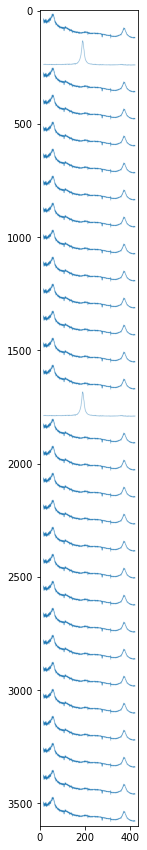

In [126]:
fig = plt.figure(figsize=(3,15))
img = plt.imread("spectra30_2randdiff_highres/stack30_2diff_highres_2.png")
plt.imshow(img)